In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import requests
from datetime import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
class DataGenerator:
    def __init__(self, interval, date_start, date_stop):
        self.interval = interval
        self.date_start = datetime.strptime(date_start, '%d/%m/%y').timestamp()*1000
        self.date_stop = datetime.strptime(date_stop, '%d/%m/%y').timestamp()*1000
        self.data = self.get_candlestick_data()

    def get_candlestick_data(self):
        """Retrieves Binance Api data: splits whole interval into smaller intervals and requests data for it"""
        df = pd.DataFrame(requests.get(
                self.get_url_with_parameters(self.date_start, self.offset_timestamp(self.date_start, 1))).json())
        for start, end in self.create_timestamp_data():
            df = df.append(pd.DataFrame(requests.get(self.get_url_with_parameters(start, end)).json()),
                           ignore_index=True) \
                if end < self.date_stop else df.append(
                pd.DataFrame(requests.get(self.get_url_with_parameters(start, self.date_stop)).json()),
                ignore_index=True)
        df.columns = self.get_candlesticks_df_columns()
        df['date'] = pd.to_datetime(df.open_tstmp, unit='ms', utc=True)
        return df

    @staticmethod
    def get_candlesticks_df_columns():
        return ['open_tstmp', 'open', 'high', 'low', 'close', 'vol', 'close_tstmp', 'quote_vol', 'trades',
                'taker_base', 'taker_quote', 'excess_column']

    def create_timestamp_data(self):
        """Retrieves all timestamps that need to be received from API (API data limits)"""
        return [[self.offset_timestamp(self.date_start, i+1), self.offset_timestamp(self.date_start, i+2)-1] for i in range(self.calculate_api_calls_number())]

    def calculate_api_calls_number(self):
        """Calculate how many times API has to be requested for data"""
        return math.ceil((self.date_stop - self.date_start)/(self.interval_to_ms()*500))

    def interval_to_ms(self):
        """Change interval to milliseconds"""
        return int(self.interval[:-1])*60000 if self.interval[-1] == 'm' else int(self.interval[:-1])*3600000

    def offset_timestamp(self, start, times=0):
        """Offset timestamp for data retrieval"""
        return start + 500*self.interval_to_ms()*times

    def get_url_with_parameters(self, start, stop):
        """Get URL with parameters: interval, start and end time"""
        return f"https://api.binance.com/api/v3/klines?symbol=BTCUSDT&interval={self.interval}&startTime={str(start)[:-2]}&endTime={str(stop)[:-2]}"

    def data_to_csv(self):
        """Save data to csv file"""
        self.data.to_csv(f'{SAVE_DATA_PATH}data_{self.date_start}_{self.interval}.csv')

In [3]:
price_data = DataGenerator('1m', '08/06/22', '09/06/22').data['close']

In [4]:
price_data_df = pd.DataFrame(price_data)
price_data_df.columns = ['x']
price_data_df['y'] = price_data_df['x'].shift(1)
price_data_df.dropna(inplace=True)

In [5]:
model = keras.Sequential()
model.add(layers.LSTM(64))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10))
model.add(layers.Dense(1))

In [6]:
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_x.fit(np.array(price_data_df.x).reshape(-1, 1))
scaler_y.fit(np.array(price_data_df.y).reshape(-1, 1))
X = scaler_x.transform(np.array(price_data_df.x).reshape(-1, 1))
y = scaler_y.transform(np.array(price_data_df.y).reshape(-1, 1))

In [7]:
price_data_scaled_df = pd.DataFrame([X.reshape(1, -1)[0], y.reshape(1, -1)[0]]).transpose()

In [8]:
train = price_data_scaled_df.iloc[:int(len(price_data_df)*0.95)]
train.columns = ['x', 'y']
test = price_data_scaled_df.iloc[int(len(price_data_df)*0.95):]
test.columns = ['x', 'y']

In [9]:
Xtrain, ytrain = train.x, train.y
Xtest, ytest = test.x, test.y

In [10]:
Xtrain = np.array(Xtrain).reshape((Xtrain.shape[0], 1, 1))
Xtest = np.array(Xtest).reshape((Xtest.shape[0], 1, 1))

In [11]:
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1),
    metrics=["mse"],
)

In [12]:
model.fit(
    Xtrain, ytrain, batch_size=128, epochs=32
)

Epoch 1/32
11/11 [==============================] - 2s 3ms/step - loss: 0.1246 - mse: 0.1246
Epoch 2/32
11/11 [==============================] - 0s 4ms/step - loss: 0.0274 - mse: 0.0274
Epoch 3/32
11/11 [==============================] - 0s 4ms/step - loss: 0.0027 - mse: 0.0027
Epoch 4/32
11/11 [==============================] - 0s 4ms/step - loss: 0.0045 - mse: 0.0045
Epoch 5/32
11/11 [==============================] - 0s 3ms/step - loss: 0.0018 - mse: 0.0018
Epoch 6/32
11/11 [==============================] - 0s 3ms/step - loss: 0.0011 - mse: 0.0011    
Epoch 7/32
11/11 [==============================] - 0s 3ms/step - loss: 0.0011 - mse: 0.0011    
Epoch 8/32
11/11 [==============================] - 0s 3ms/step - loss: 9.9107e-04 - mse: 9.9107e-04
Epoch 9/32
11/11 [==============================] - 0s 2ms/step - loss: 7.9824e-04 - mse: 7.9824e-04
Epoch 10/32
11/11 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013    
Epoch 11/32
11/11 [======================

In [13]:
y_pred = model.predict(Xtest)

3/3 [==============================] - 0s 2ms/step


In [14]:
y_pred = scaler_y.inverse_transform(y_pred)

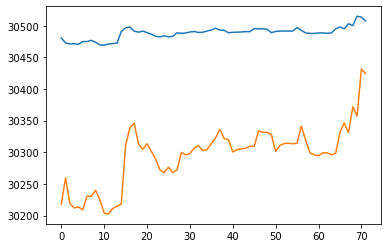

In [15]:
plt.plot(y_pred)
plt.plot(pd.to_numeric(price_data_df.y.iloc[int(len(price_data_df)*0.95):].values))